<a href="https://colab.research.google.com/github/MasaniselviGanesan/Sentimental-Analysis/blob/main/LSTM_BERT_ROBERTA_XGboostmodel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


📊 Classification Report (XGBoost Stacking Ensemble):

              precision    recall  f1-score   support

    negative       0.99      0.91      0.95      1835
     neutral       0.81      0.94      0.87       620
    positive       0.89      0.98      0.93       473

    accuracy                           0.93      2928
   macro avg       0.89      0.94      0.92      2928
weighted avg       0.93      0.93      0.93      2928



/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


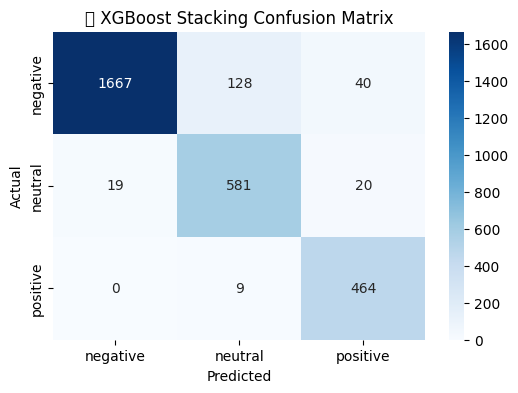

In [ ]:
# ✅ Stacking Ensemble Sentiment Classifier (BERT + LSTM + RoBERTa) with XGBoost & Class Weights

# ✅ STEP 1: Install & Import Required Libraries
!pip install transformers scikit-learn xgboost -q

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier
import pickle

# ✅ STEP 2: Mount Google Drive (if using Colab)
#from google.colab import drive
#drive.mount('/content/drive')

# ✅ STEP 3: Load .npy Files from Google Drive
bert_probs = np.load('/content/drive/MyDrive/Sentimental-Analysis/bert_probs.npy')
lstm_probs = np.load('/content/drive/MyDrive/Sentimental-Analysis/lstm_probs.npy')
roberta_probs = np.load('/content/drive/MyDrive/Sentimental-Analysis/roberta_probs.npy')
val_labels = np.load('/content/drive/MyDrive/Sentimental-Analysis/val_labels.npy')

# ✅ STEP 4: Stack Predictions into Meta Features
X_meta = np.hstack([bert_probs, lstm_probs, roberta_probs])  # Shape: (N, 9)
y_meta = val_labels

# ✅ STEP 5: Compute Class Weights
classes = np.unique(y_meta)
class_weights = compute_class_weight('balanced', classes=classes, y=y_meta)
class_weight_dict = dict(zip(classes, class_weights))

# ✅ STEP 6: Train XGBoost as Meta-Classifier with Class Weights
meta_model = XGBClassifier(n_estimators=100, learning_rate=0.1, objective='multi:softmax', num_class=3)

# XGBoost does not accept class_weight directly, so use sample_weight
sample_weights = np.array([class_weight_dict[label] for label in y_meta])
meta_model.fit(X_meta, y_meta, sample_weight=sample_weights)

# ✅ STEP 7: Predict and Evaluate
final_preds = meta_model.predict(X_meta)

print("\n📊 Classification Report (XGBoost Stacking Ensemble):\n")
print(classification_report(y_meta, final_preds, target_names=['negative', 'neutral', 'positive']))

# ✅ STEP 8: Confusion Matrix
cm = confusion_matrix(y_meta, final_preds)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['negative', 'neutral', 'positive'],
            yticklabels=['negative', 'neutral', 'positive'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("🧠 XGBoost Stacking Confusion Matrix")
plt.show()

# ✅ STEP 9: Save Final Meta-Model
with open('/content/drive/MyDrive/Sentimental-Analysis/stacking_xgboost_model.pkl', 'wb') as f:
    pickle.dump(meta_model, f)

# ✅ STEP 10: Save Predictions (Optional)
np.save('/content/drive/MyDrive/Sentimental-Analysis/ensemble_final_preds.npy', final_preds)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

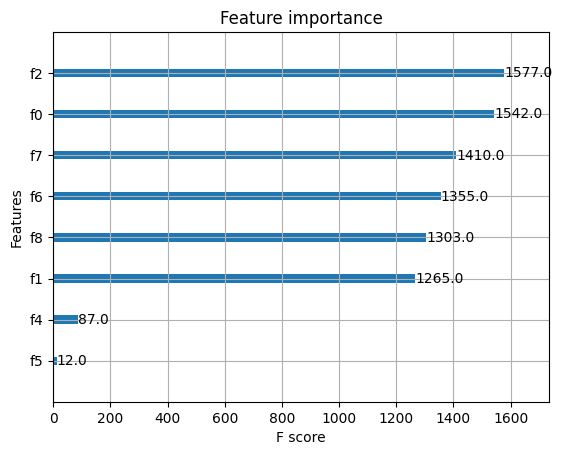

In [ ]:
from xgboost import plot_importance
plot_importance(meta_model)
